In [52]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
#import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import astropy.units as u
import numpy as np
from scipy.optimize import leastsq
import pylab as plt
tpf = search_targetpixelfile('249914869', mission='K2',campaign=15,cadence='short').download()

In [32]:
EPIC=249914869
campaign_num=15

In [54]:
tpf

KeplerTargetPixelFile Object (ID: 249914869)

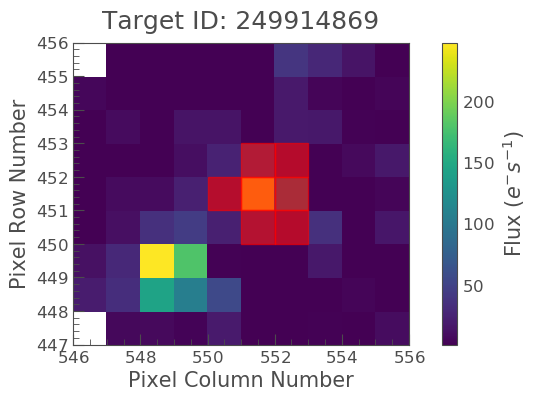

In [55]:
%matplotlib inline
tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='red')

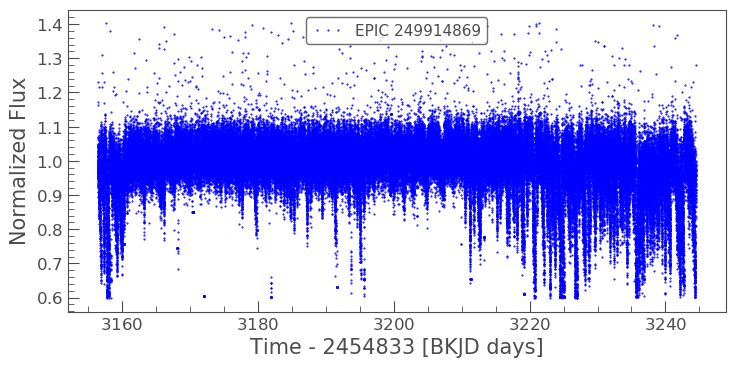

In [56]:
import matplotlib.pyplot as plt

user_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers().fill_gaps()
user_lc.plot(marker='.',linestyle='None',color='blue')
#plt.ylim(0.9,1.1)

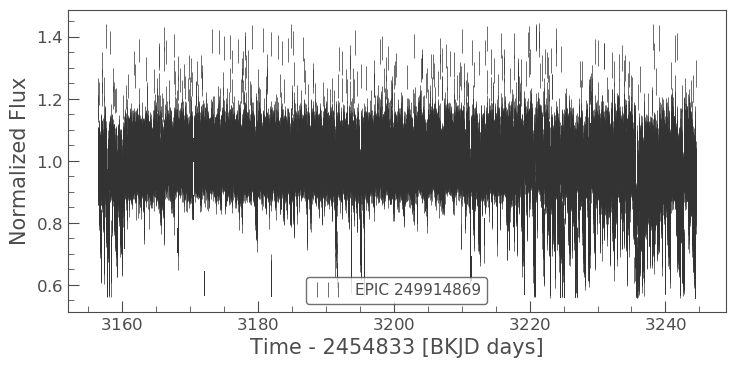

In [57]:
user_lc.errorbar();

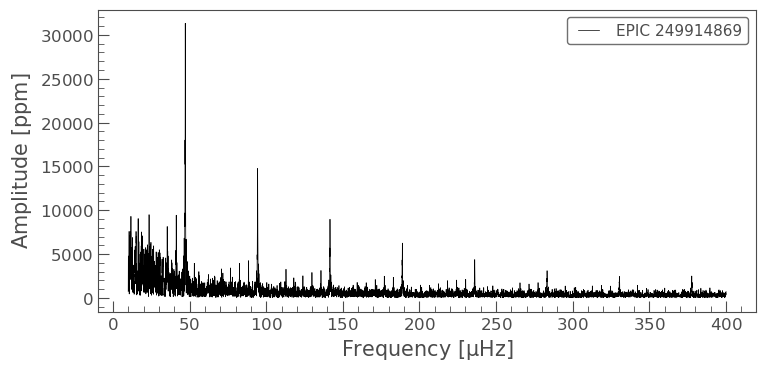

In [58]:
p = user_lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.24517842 d>

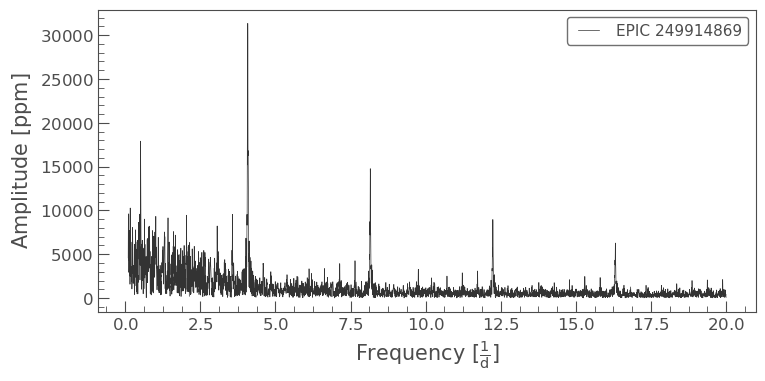

In [59]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


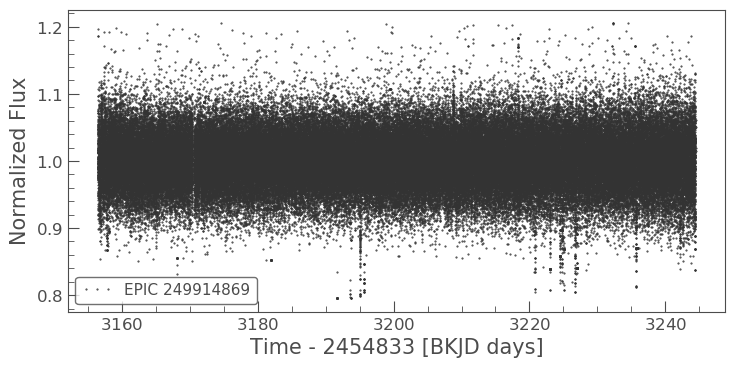

In [60]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool)).normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()
clc.plot(linestyle='none',marker='.')

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.1025056 d>

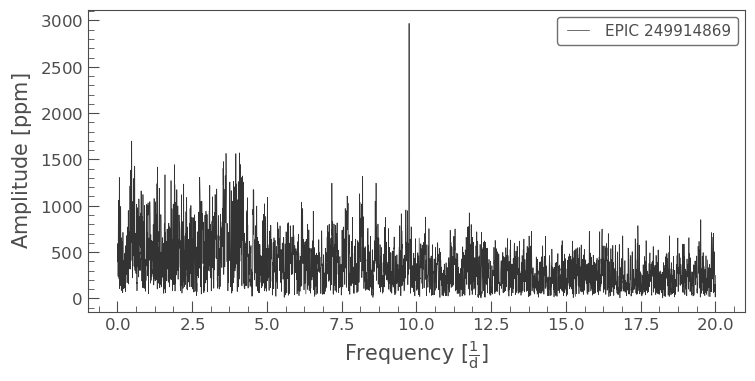

In [61]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

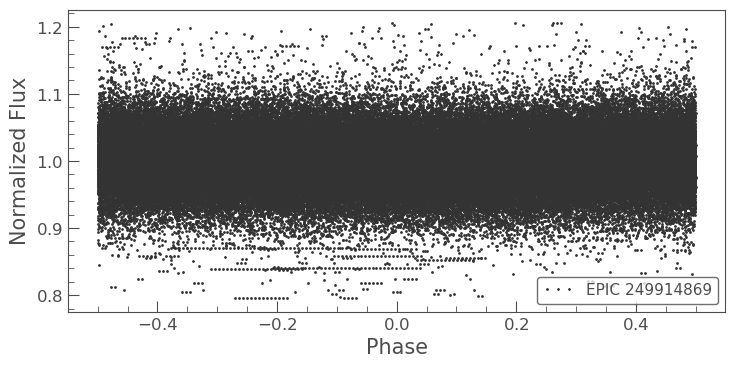

In [62]:
folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

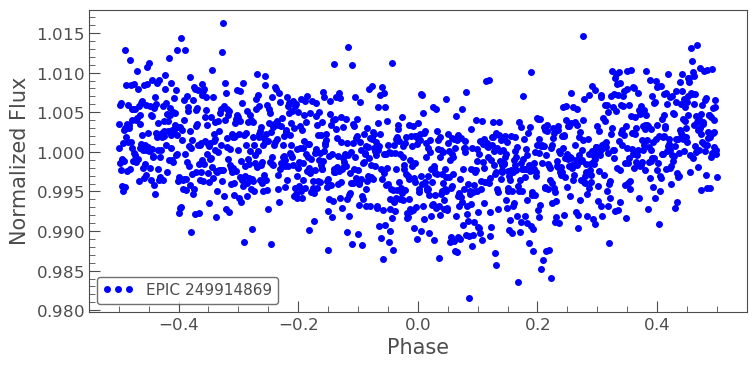

In [63]:
bin_folded_lc = folded_lightcurve.bin(100,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue',title='K2')

In [64]:
corrector=lk.SFFCorrector(lc)
new_lc = corrector.correct(lc.centroid_col,lc.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


0.10252948369492497 d


<Quantity 9.75329207 1 / d>

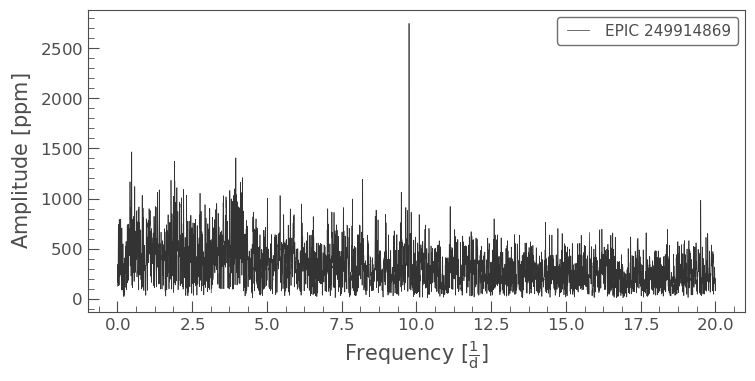

In [65]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
print(periodogram.period_at_max_power)
periodogram.frequency_at_max_power


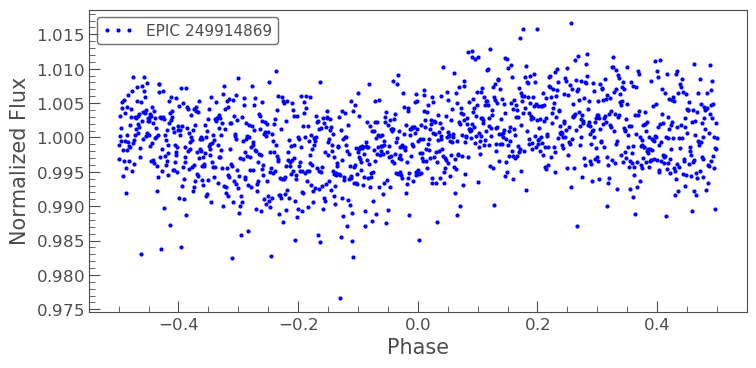

In [66]:
folded_lightcurve = new_lc.fold(periodogram.period_at_max_power.value)

bin_folded_lc = folded_lightcurve.bin(100,method='median')
bin_folded_lc.plot(marker='.',linestyle='None',markersize=4,color='blue',title='K2')

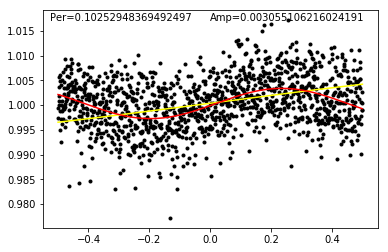

In [67]:
          N = len(bin_folded_lc.flux) # number of data points
          t = np.linspace(-0.5, 0.5, N)
          guess_mean = np.mean(bin_folded_lc.flux)
          guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
          guess_phase = 0
          guess_freq = 1
          guess_amp = 1
          data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
          optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
          est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
          data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
          fine_t = np.arange(-0.5,0.5,0.001)
          data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
          plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
          plt.plot(t, data_first_guess, label='first guess', color='yellow')
          plt.plot(fine_t, data_fit, label='after fitting', color='red')
          plt.text(-0.525,max(bin_folded_lc.flux),"Per=%s"%(periodogram.period_at_max_power.value))
          plt.text(0,max(bin_folded_lc.flux),"Amp=%s"%(est_amp))
          plt.show()

In [68]:
len(bin_folded_lc.flux)

1267

In [69]:
     first_time=[]
     second_time=[]
     third_time=[]
     fourth_time=[]
     fifth_time=[]
     sixth_time=[]
     seventh_time=[]
     eighth_time=[]
     ninth_time=[]
     tenth_time=[]
     first_flux=[]
     second_flux=[]
     third_flux=[]
     fourth_flux=[]
     fifth_flux=[]
     sixth_flux=[]
     seventh_flux=[]
     eighth_flux=[]
     ninth_flux=[]
     tenth_flux=[]

     row=0
     first_day=clc.time[0]
     num_data=clc.time.size
     last_day=clc.time[num_data-1]
     num_days=last_day-first_day
     sep_length=num_days/10
    
     for i in clc.time:
         if (i<(first_day+sep_length)):
             first_time.append(i)
             first_flux.append(clc.flux[row])
         if (i>(first_day+sep_length)) and (i<(first_day+2*sep_length)):
             second_time.append(i)
             second_flux.append(clc.flux[row])
         if (i>(first_day+2*sep_length)) and (i<(first_day+3*sep_length)):
             third_time.append(i)
             third_flux.append(clc.flux[row])
         if (i>(first_day+3*sep_length)) and (i<(first_day+4*sep_length)):
             fourth_time.append(i)
             fourth_flux.append(clc.flux[row])
         if (i>(first_day+4*sep_length)) and (i<(first_day+5*sep_length)):
             fifth_time.append(i)
             fifth_flux.append(clc.flux[row])
         if (i>(first_day+5*sep_length)) and (i<(first_day+6*sep_length)):
             sixth_time.append(i)
             sixth_flux.append(clc.flux[row])
         if (i>(first_day+6*sep_length)) and (i<(first_day+7*sep_length)):
             seventh_time.append(i)
             seventh_flux.append(clc.flux[row])
         if (i>(first_day+7*sep_length)) and (i<(first_day+8*sep_length)):
             eighth_time.append(i)
             eighth_flux.append(clc.flux[row])
         if (i>(first_day+8*sep_length)) and (i<(first_day+9*sep_length)):
             ninth_time.append(i)
             ninth_flux.append(clc.flux[row])
         if (i>(first_day+9*sep_length)) and (i<(first_day+10*sep_length)):
             tenth_time.append(i)
             tenth_flux.append(clc.flux[row])
         row=row+1

     list_of_time_lengths=[len(first_time),len(second_time),len(third_time),len(fourth_time),len(fifth_time),len(sixth_time),len(seventh_time),len(eighth_time),len(ninth_time),len(tenth_time)]
     print('DONE WITH SEPARATION')

DONE WITH SEPARATION


In [13]:
#THIS NEXT BIT IS IF WE USE THE CORRECTED LIGHT CURVE AND PRODUCE A PERIODOGRAM FOR EACH TIME SEGMENT
#THE PERIODOGRAM BEST PERIOD IS USED TO FOLD AND FIT THE DATA

1


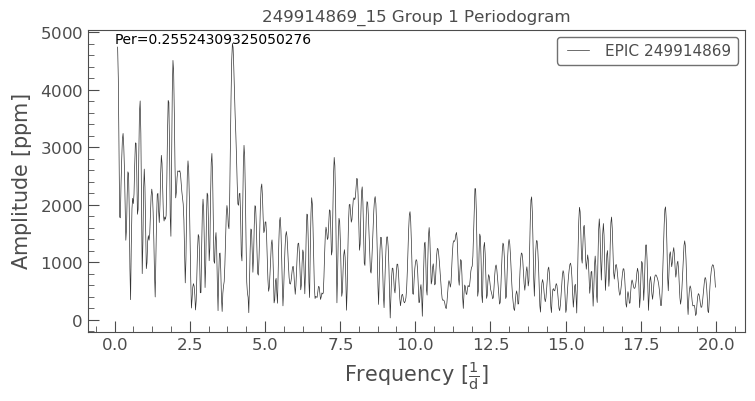

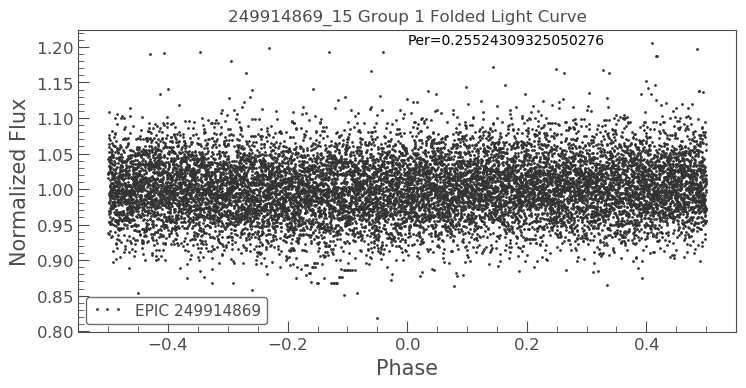

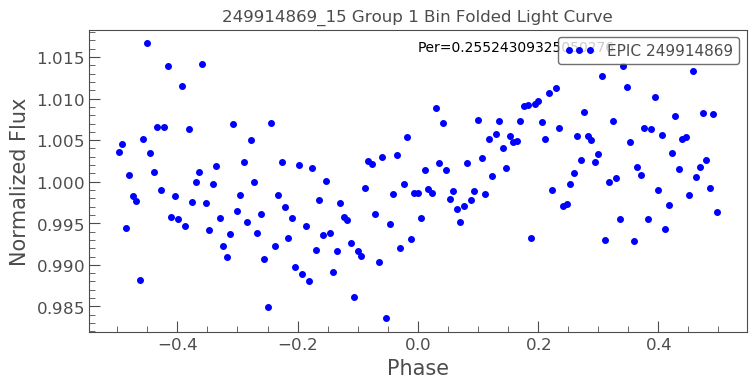

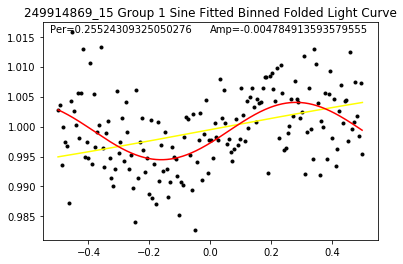

DONE WITH SEPARATION ANALYSIS
2


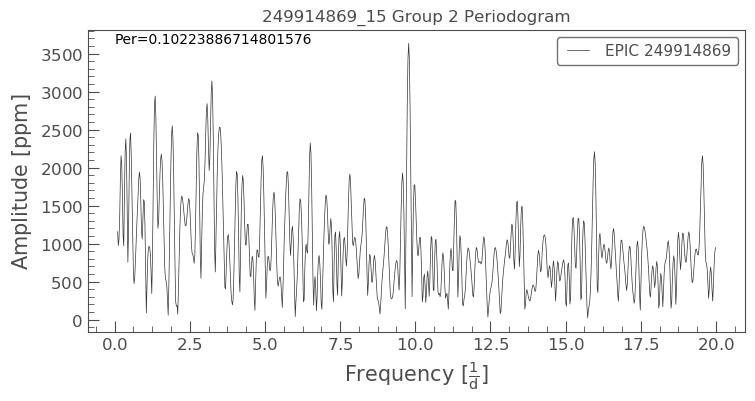

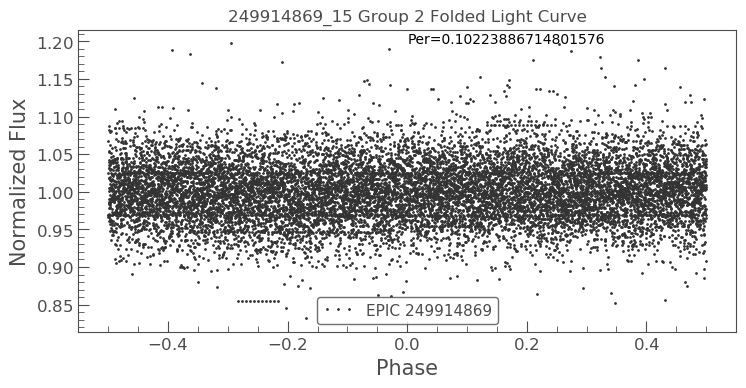

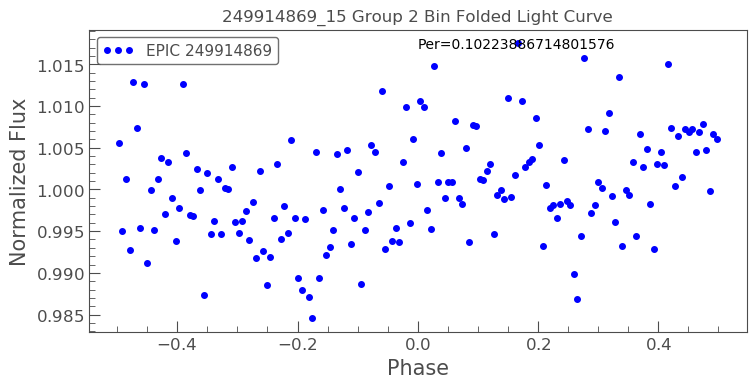

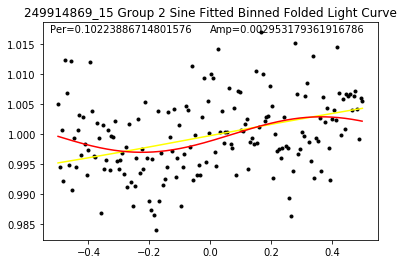

DONE WITH SEPARATION ANALYSIS
3


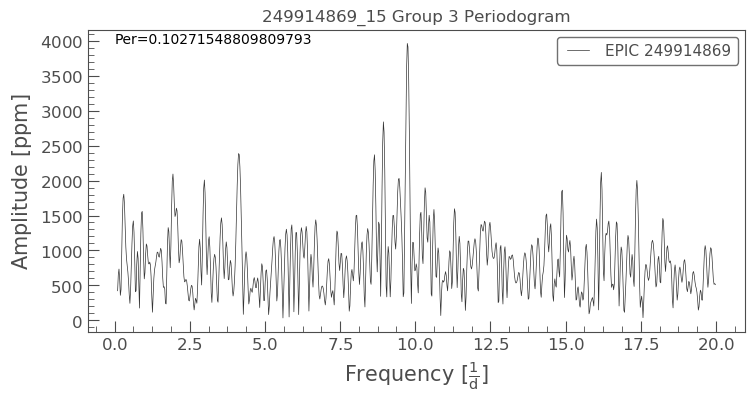

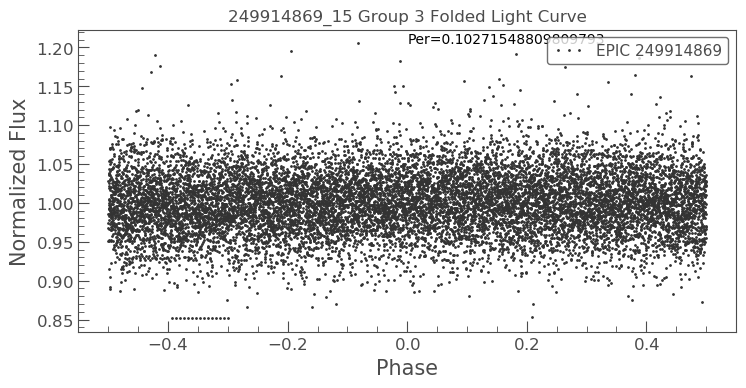

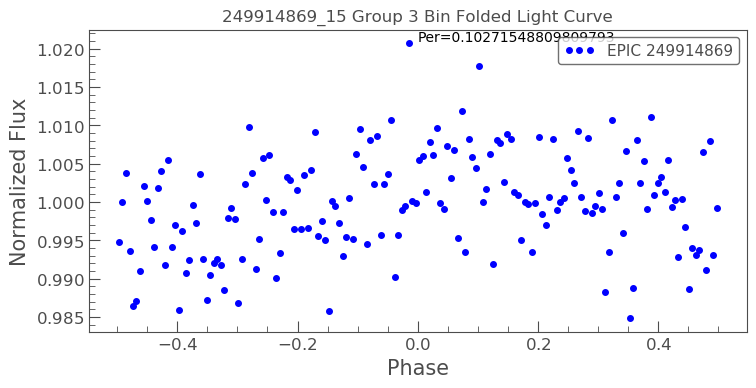

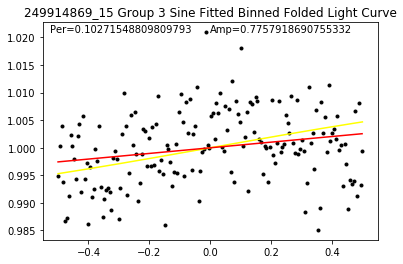

DONE WITH SEPARATION ANALYSIS
4


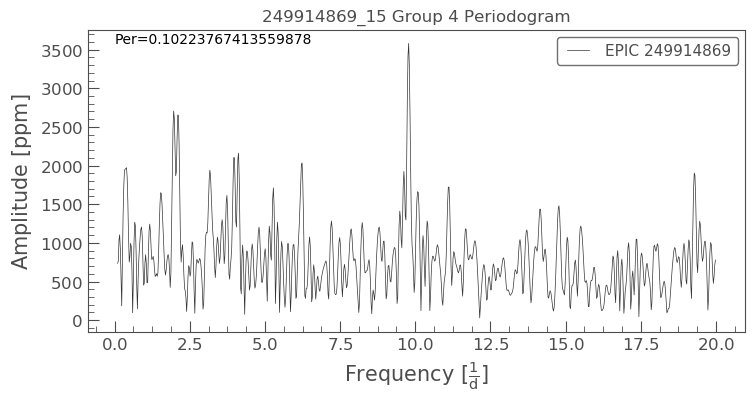

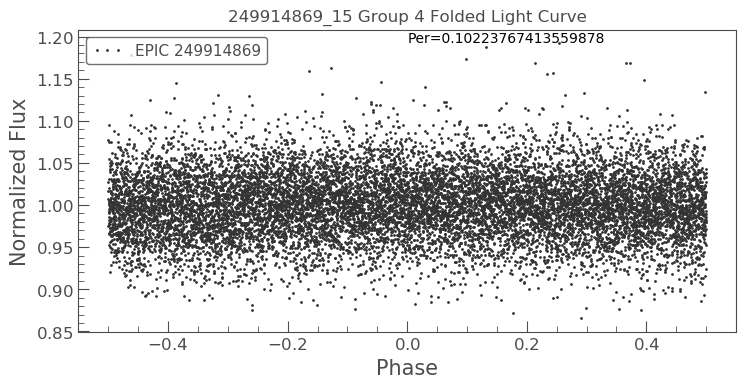

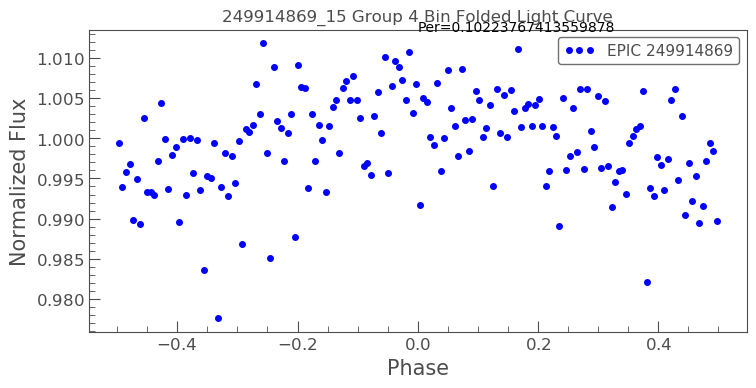

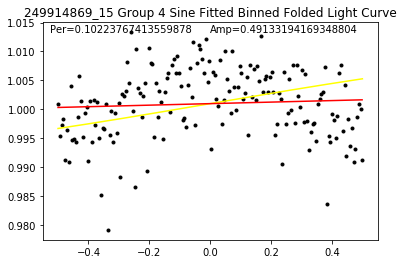

DONE WITH SEPARATION ANALYSIS
5


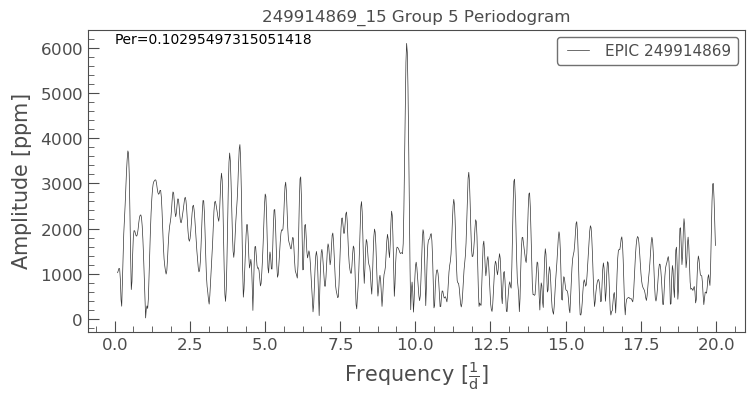

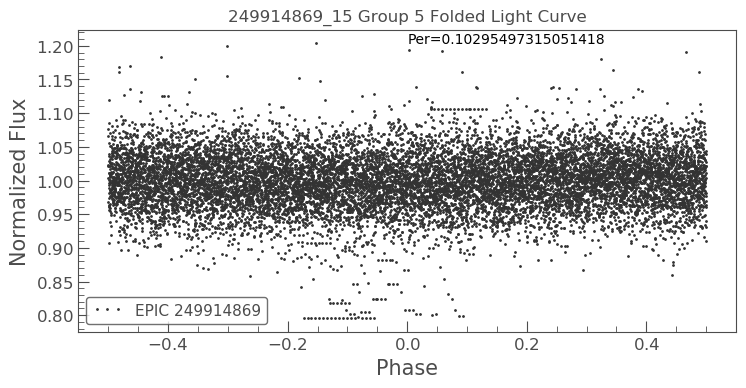

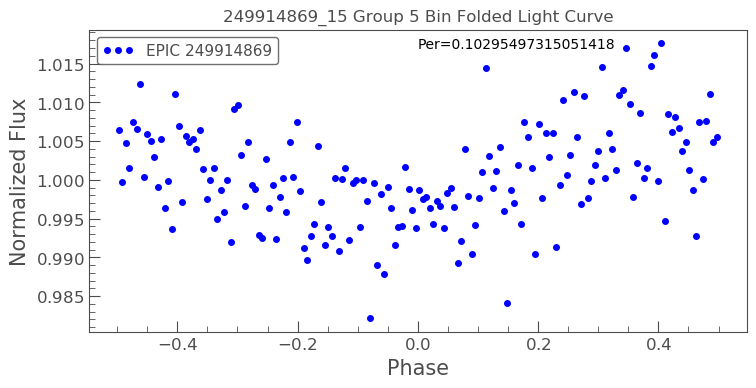

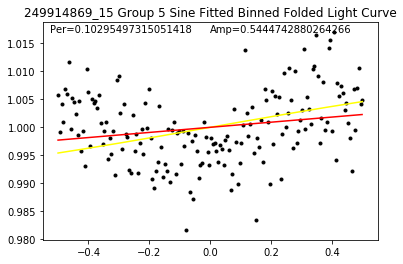

DONE WITH SEPARATION ANALYSIS
6


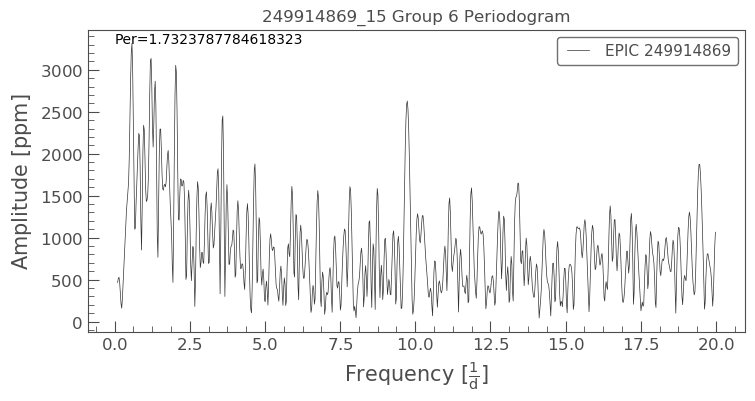

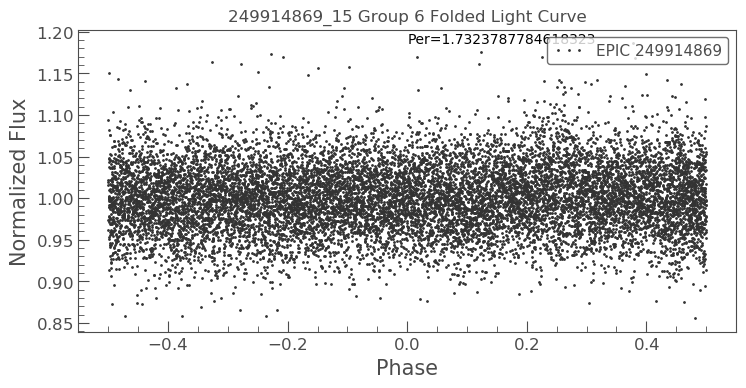

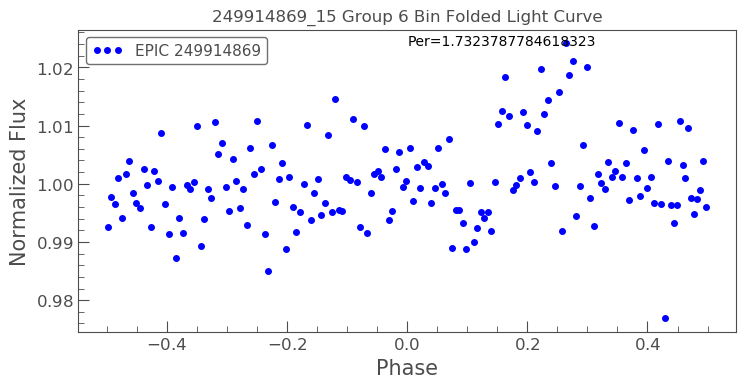

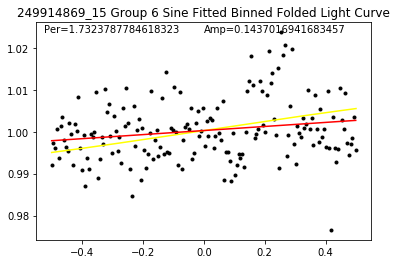

DONE WITH SEPARATION ANALYSIS
7


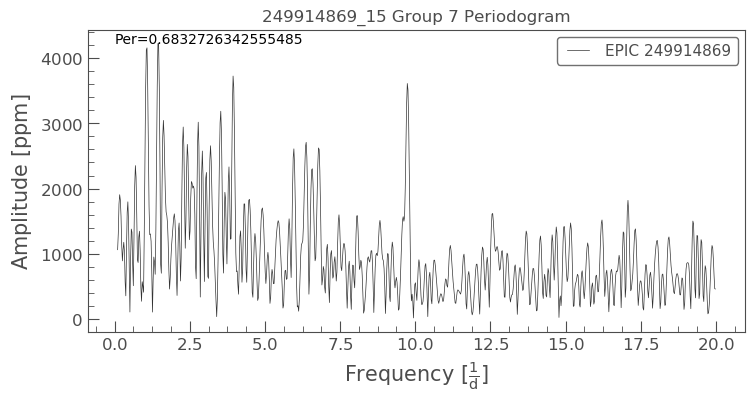

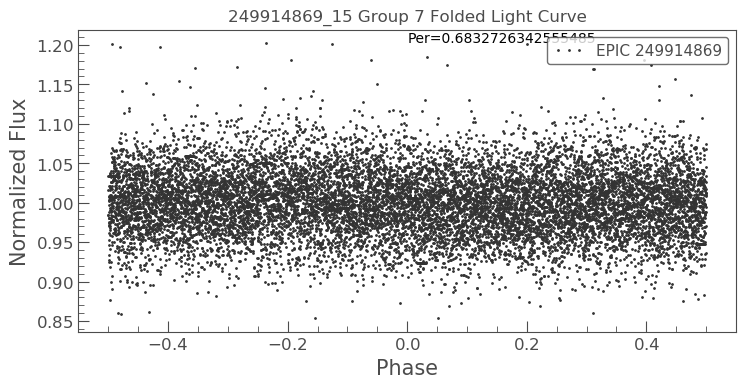

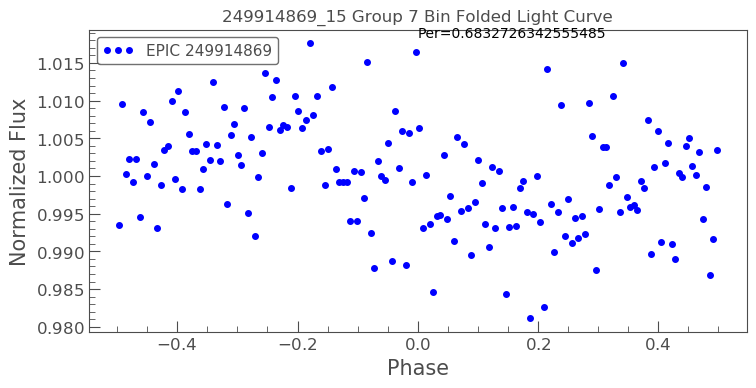

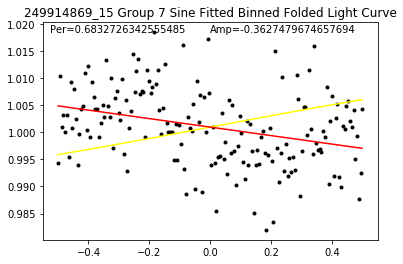

DONE WITH SEPARATION ANALYSIS
8


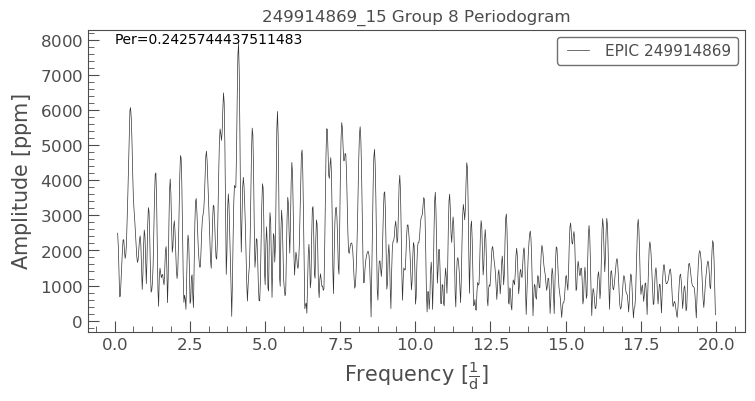

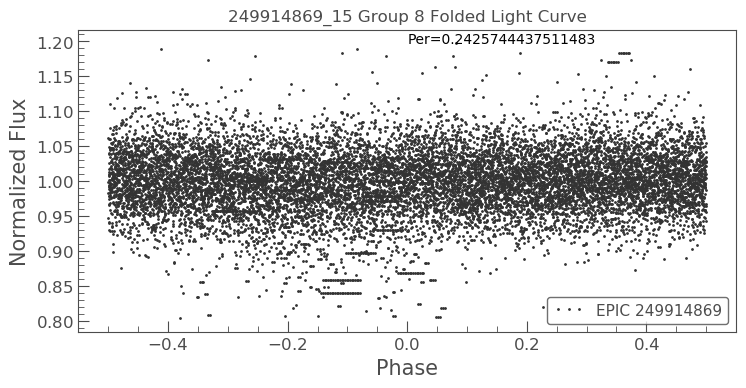

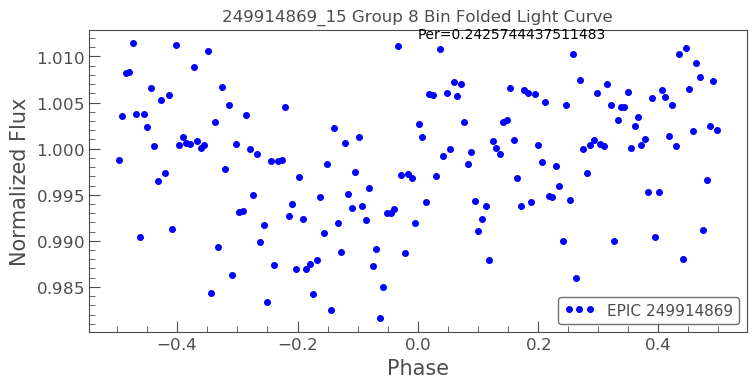

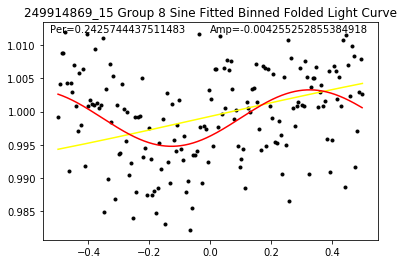

DONE WITH SEPARATION ANALYSIS
9


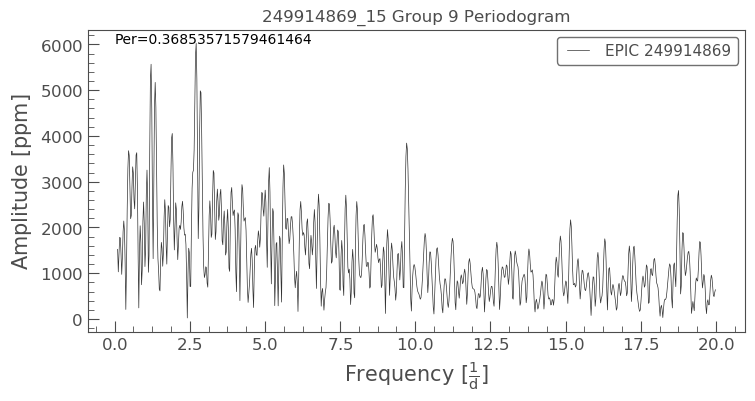

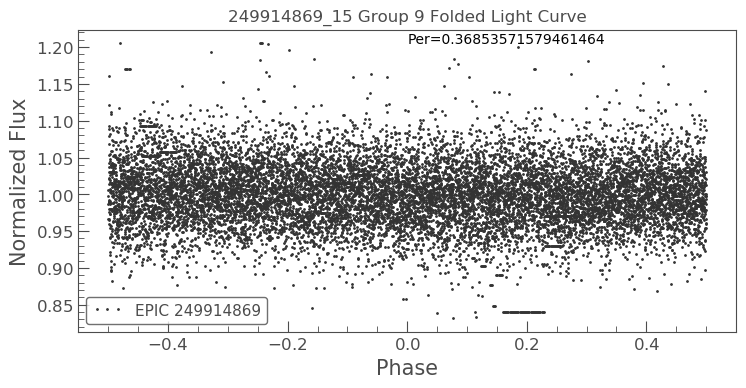

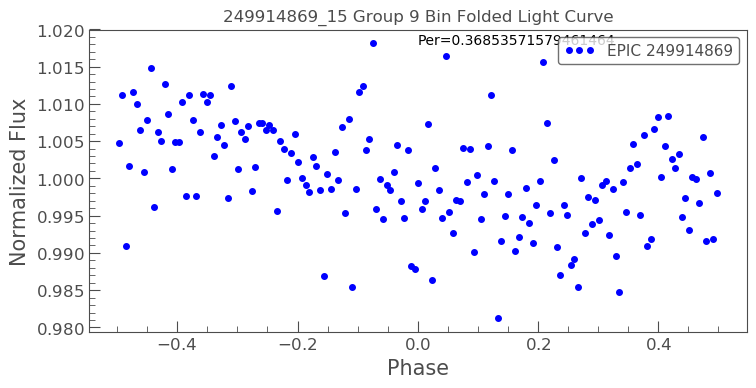

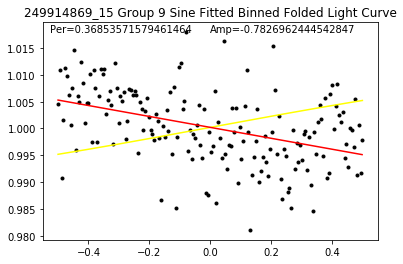

DONE WITH SEPARATION ANALYSIS
10


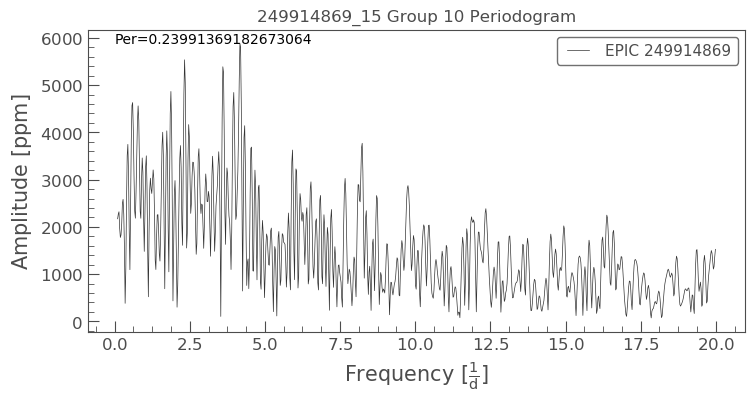

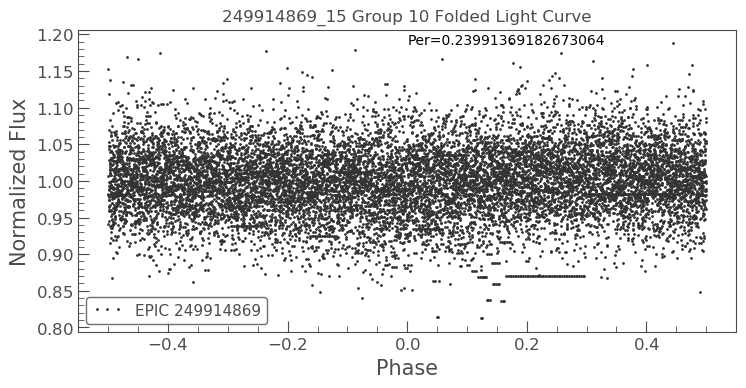

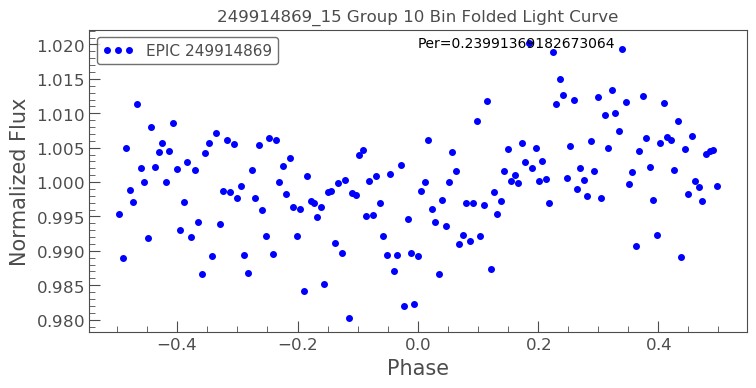

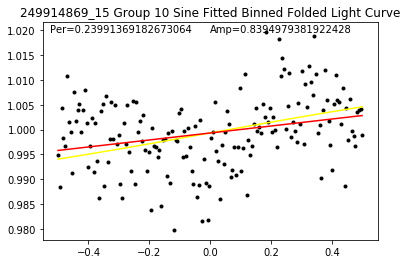

DONE WITH SEPARATION ANALYSIS


In [43]:
     x=1
     y=list_of_time_lengths[0]
     for i in range (1,11):
          print(i)

          periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[x:y], minimum_period=0.05, maximum_period =10)
          periodogram.plot()
          periodogram.period_at_max_power
          plt.text(0,periodogram.max_power.value,"Per=%s"%(periodogram.period_at_max_power.value))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i) +" Periodogram")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'peroiogram.png')

          folded_lightcurve = clc[x:y].fold(periodogram.period_at_max_power.value)
          folded_lightcurve.plot(marker='o',linestyle='none')
          plt.text(0,max(folded_lightcurve.flux),"Per=%s"%(periodogram.period_at_max_power.value))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'foldedlightcurve.png')

          bin_folded_lc = folded_lightcurve.bin(75,method='median')
          bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
          plt.text(0,max(bin_folded_lc.flux),"Per=%s"%(periodogram.period_at_max_power.value))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Bin Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'binfoldedlc.png')
          plt.clf()

          N = len(bin_folded_lc.flux) # number of data points
          t = np.linspace(-0.5, 0.5, N)
          guess_mean = np.mean(bin_folded_lc.flux)
          guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
          guess_phase = 0
          guess_freq = 1
          guess_amp = 1
          data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
          optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
          est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
          data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
          fine_t = np.arange(-0.5,0.5,0.001)
          data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
          plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
          plt.plot(t, data_first_guess, label='first guess', color='yellow')
          plt.plot(fine_t, data_fit, label='after fitting', color='red')
          plt.text(-0.525,max(bin_folded_lc.flux),"Per=%s"%(periodogram.period_at_max_power.value))
          plt.text(0,max(bin_folded_lc.flux),"Amp=%s"%(est_amp))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Sine Fitted Binned Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'sinefit.png')

          x=x+list_of_time_lengths[i-1]
          if i<10:
               y=y+list_of_time_lengths[i]
          print('DONE WITH SEPARATION ANALYSIS')
          plt.close("all")

In [ ]:
#THIS NEXT BIT WILL CORRECT EACH SEGMENT INDIVIDUALLY AND GO FROM THERE

1


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


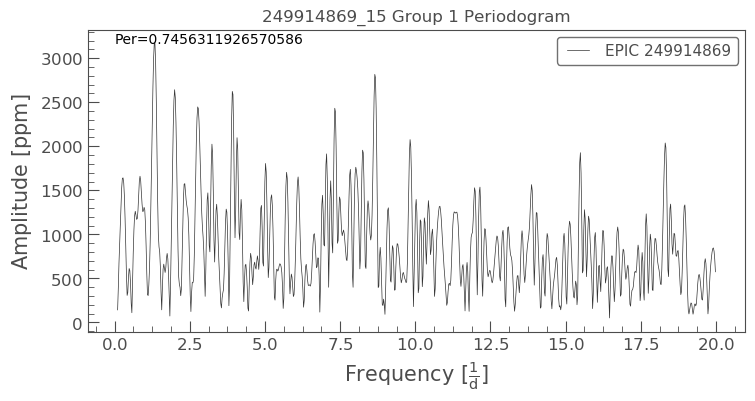

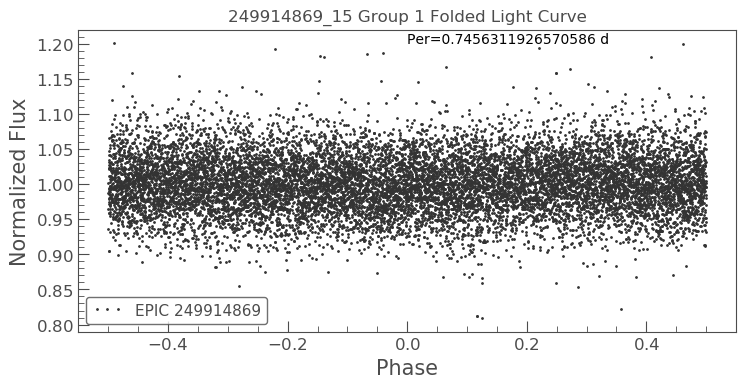

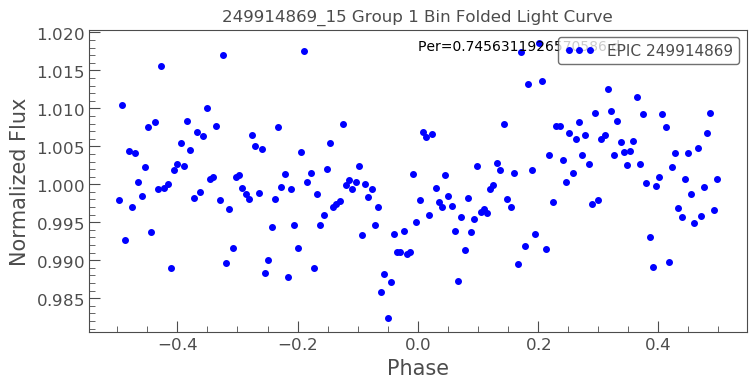

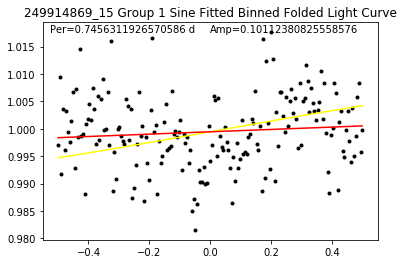

DONE WITH SEPARATION ANALYSIS
2


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


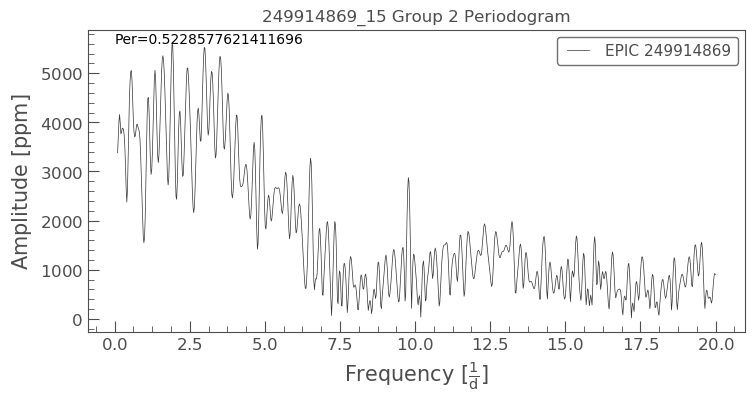

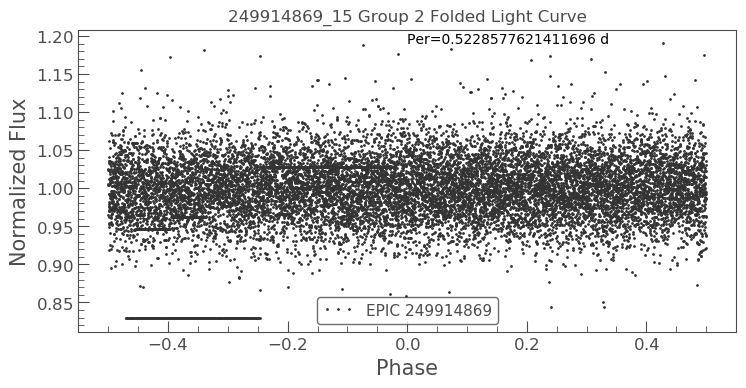

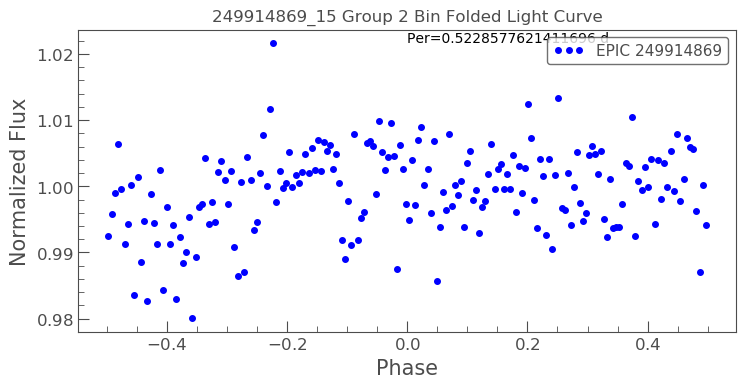

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


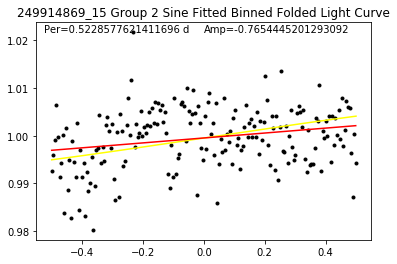

DONE WITH SEPARATION ANALYSIS
3


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


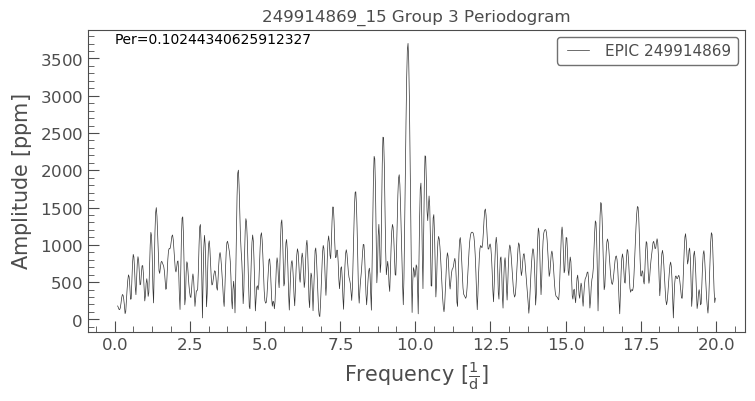

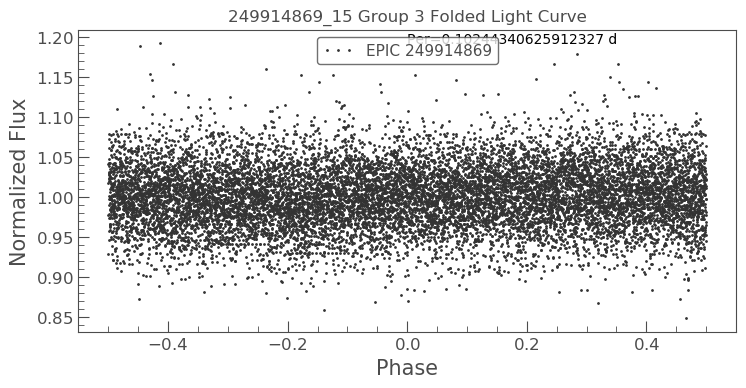

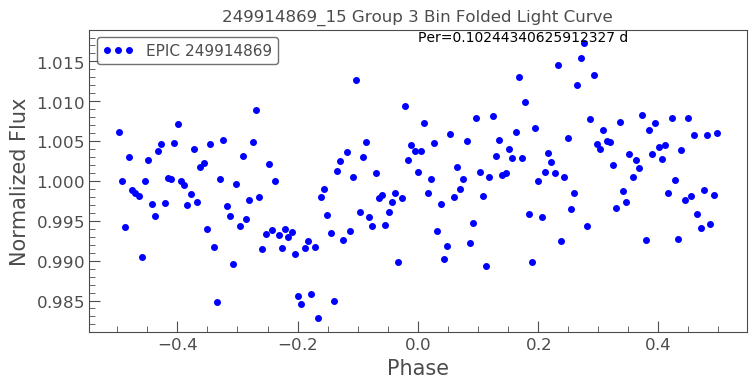

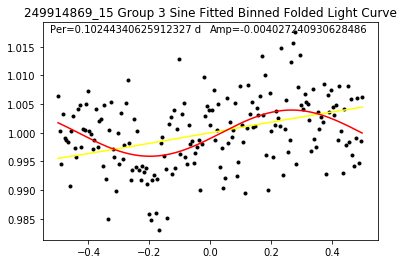

DONE WITH SEPARATION ANALYSIS
4


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


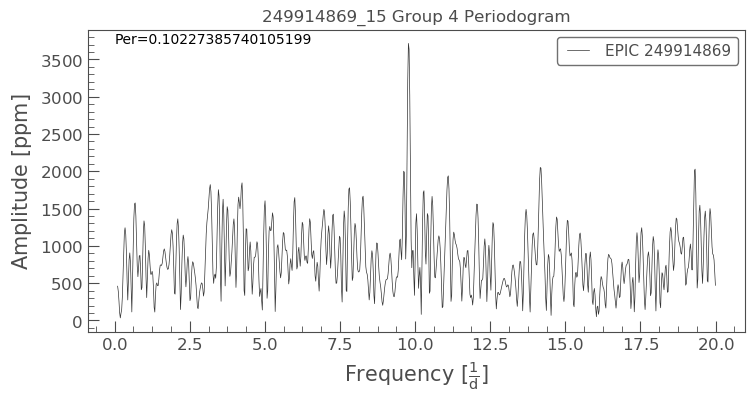

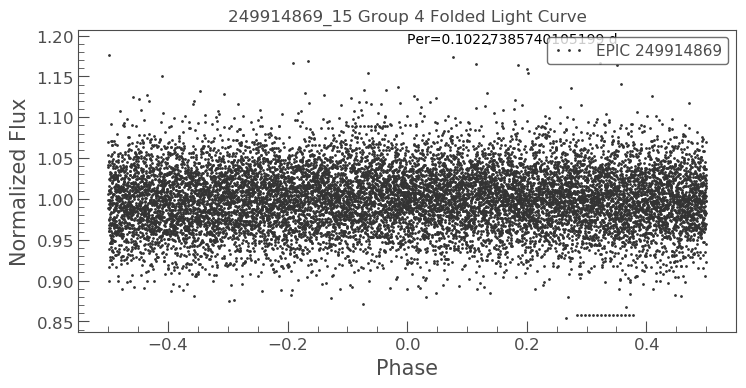

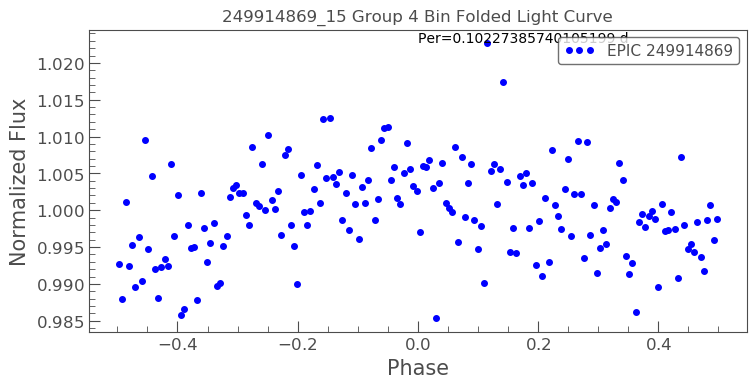

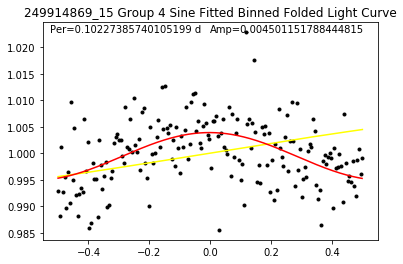

DONE WITH SEPARATION ANALYSIS
5


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


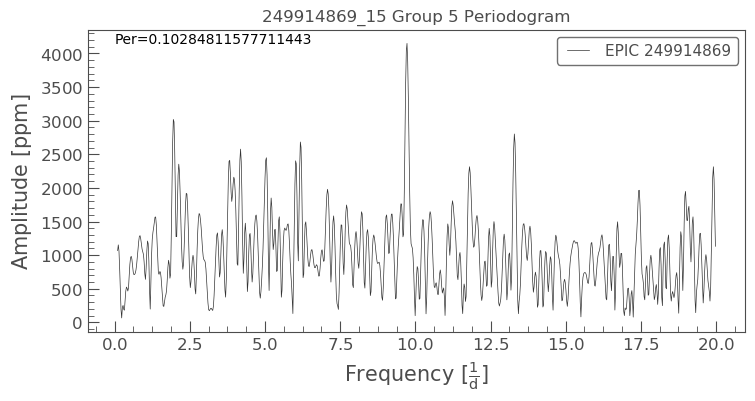

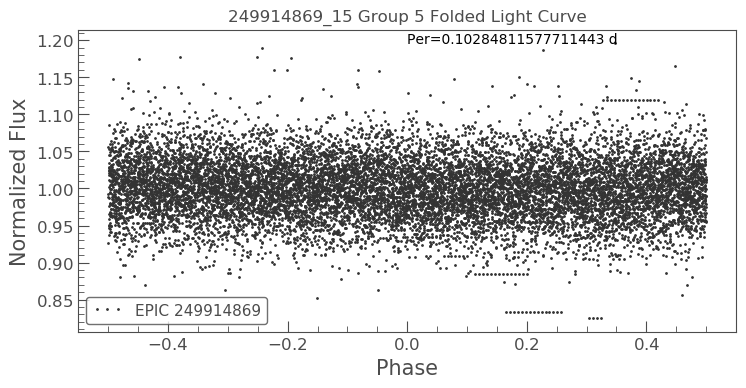

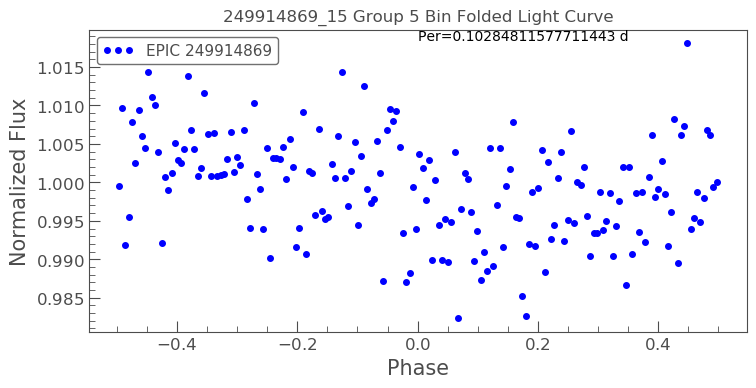

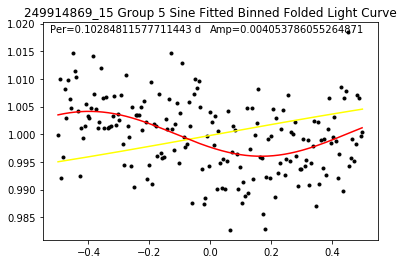

DONE WITH SEPARATION ANALYSIS
6


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


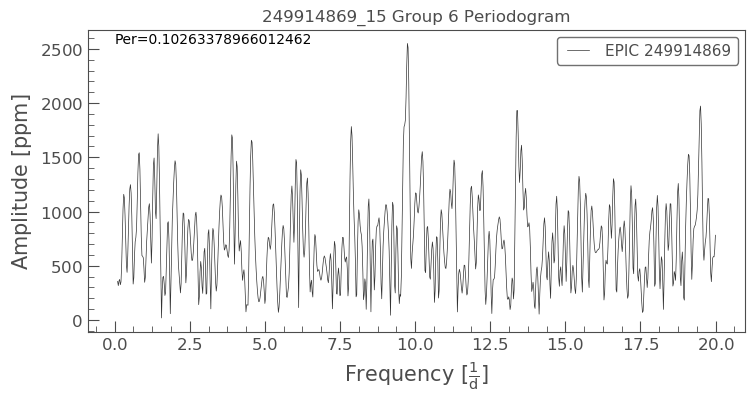

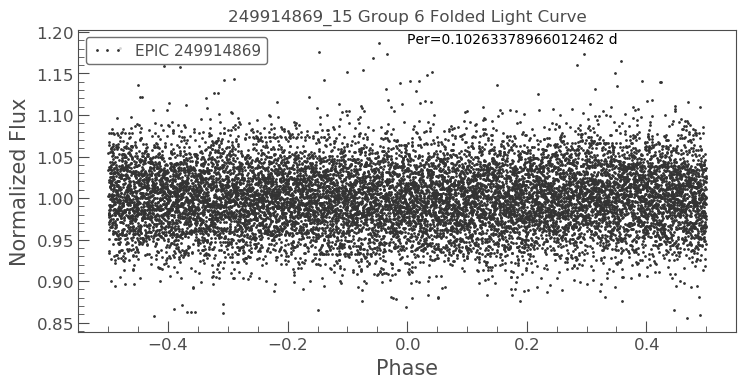

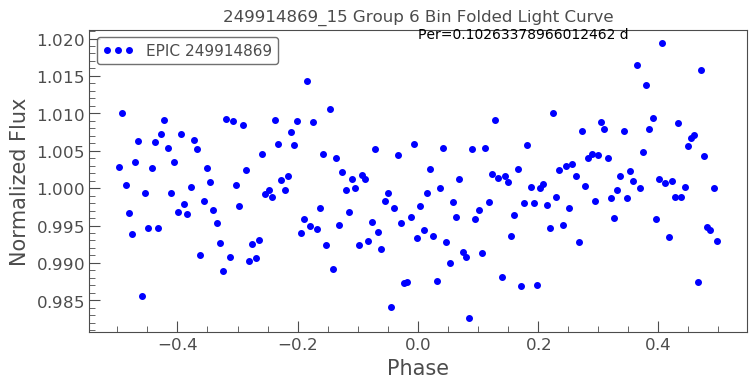

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


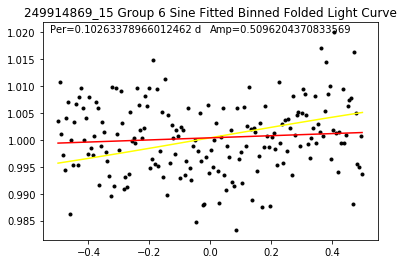

DONE WITH SEPARATION ANALYSIS
7


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


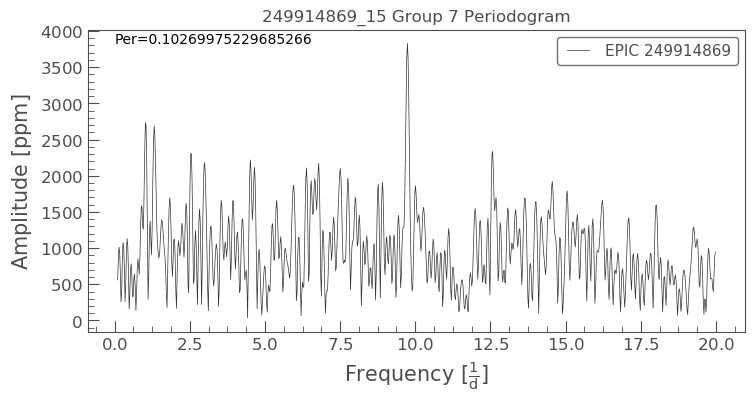

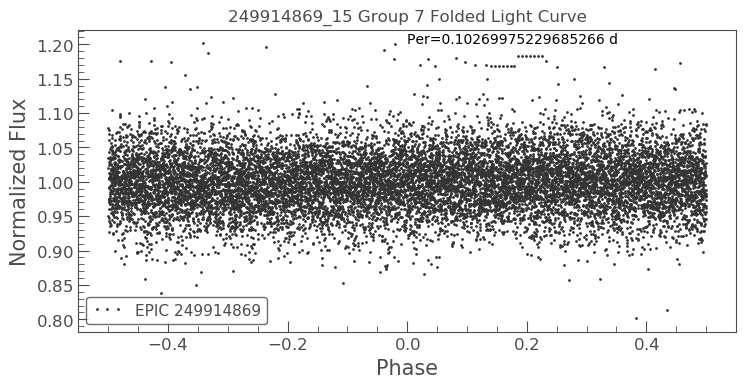

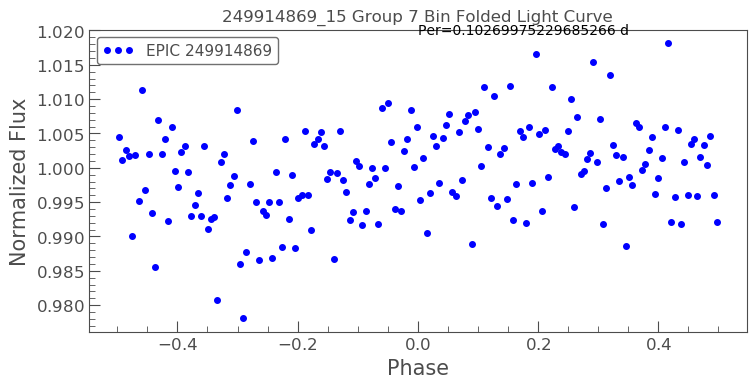

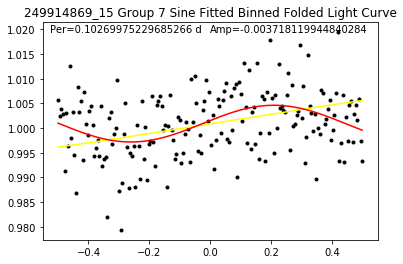

DONE WITH SEPARATION ANALYSIS
8


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


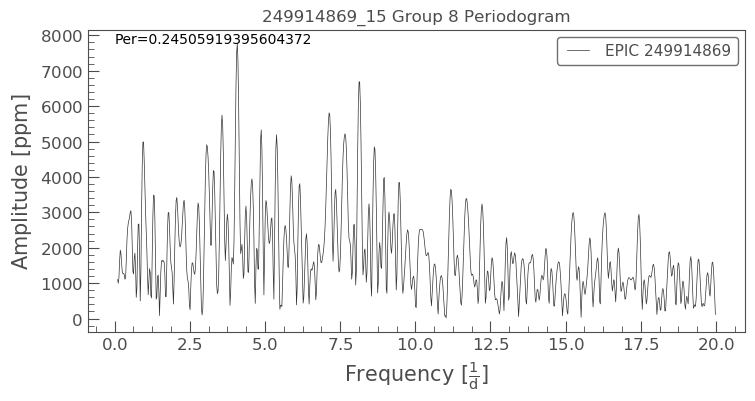

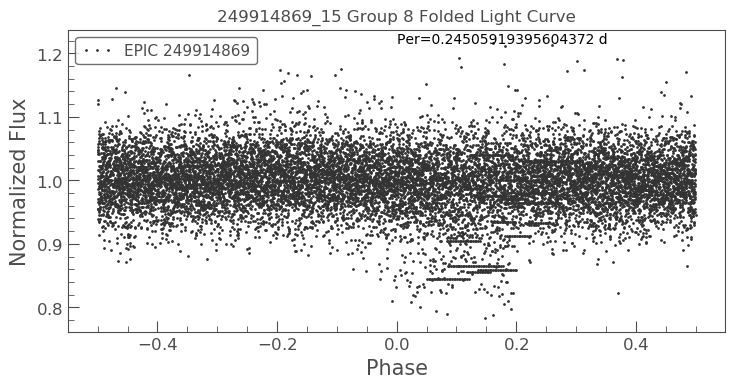

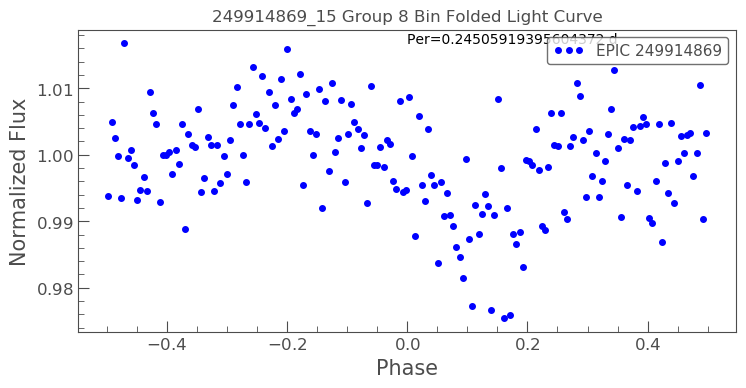

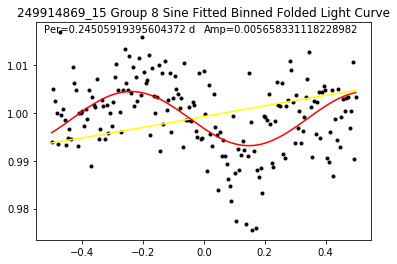

DONE WITH SEPARATION ANALYSIS
9


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


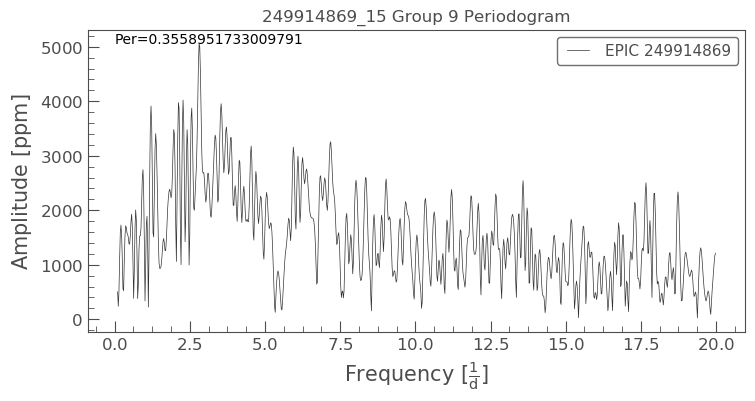

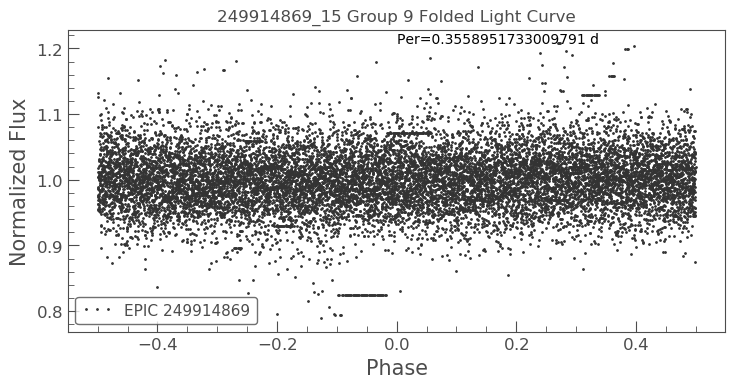

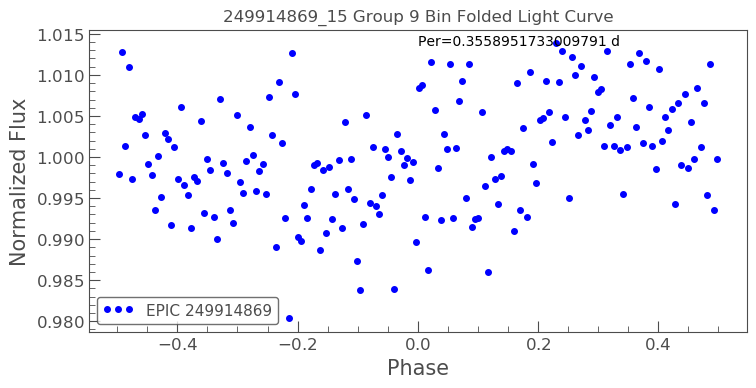

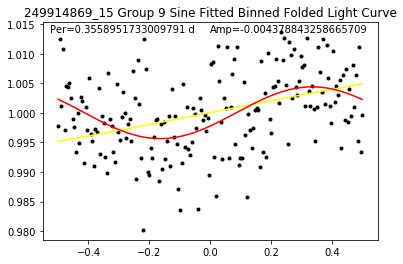

DONE WITH SEPARATION ANALYSIS
10


/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)
/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


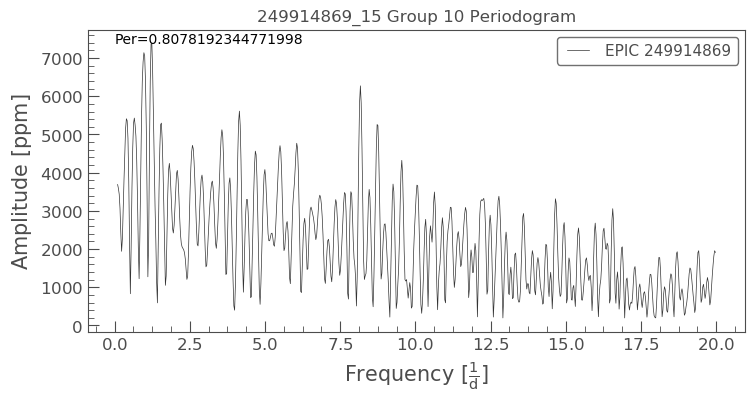

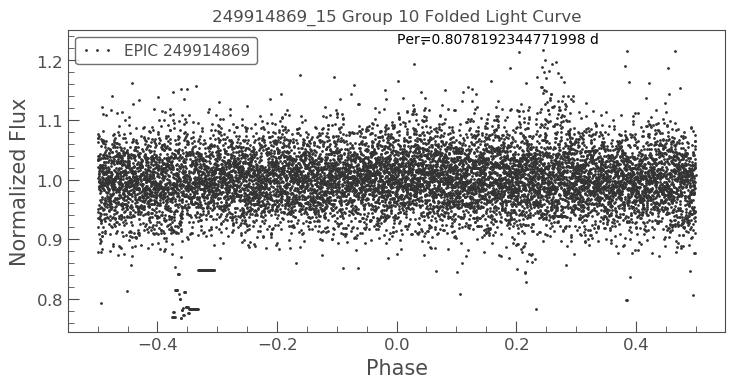

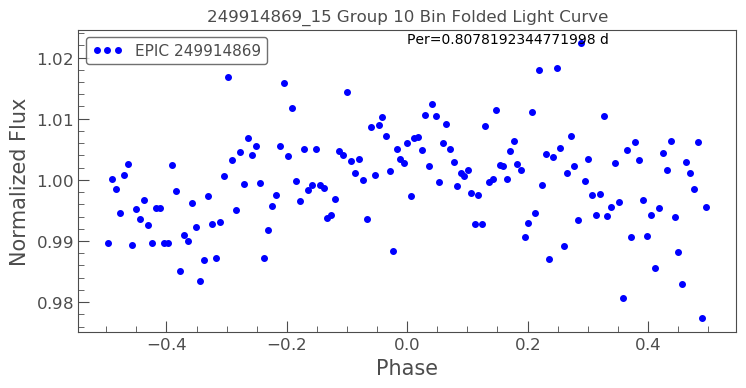

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


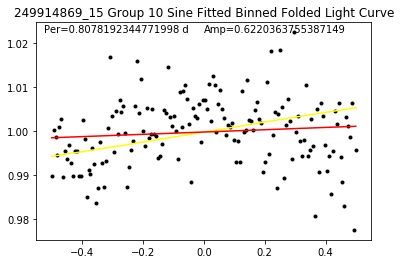

DONE WITH SEPARATION ANALYSIS


In [70]:
     x=1
     y=list_of_time_lengths[0]
     for i in range (1,11):
          print(i)

          user_lc = tpf[x:y].to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
          # Clean the light curve
          user_lc = user_lc.remove_nans().remove_outliers().fill_gaps()  

          lc = tpf[x:y].to_lightcurve().normalize().remove_nans().remove_outliers()
          clc = lc.correct(windows=10).remove_outliers().fill_gaps()

          periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =10)
          periodogram.plot()
          periodogram.period_at_max_power
          plt.text(0,periodogram.max_power.value,"Per=%s"%(periodogram.period_at_max_power.value))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i) +" Periodogram")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'peroiogram.png')

          folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
          folded_lightcurve.plot(marker='o',linestyle='none')
          plt.text(0,max(folded_lightcurve.flux),"Per=%s"%(periodogram.period_at_max_power))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'foldedlightcurve.png')

          bin_folded_lc = folded_lightcurve.bin(70,method='median')
          bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
          plt.text(0,max(bin_folded_lc.flux),"Per=%s"%(periodogram.period_at_max_power))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Bin Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'binfoldedlc.png')
          plt.clf()

          N = len(bin_folded_lc.flux) # number of data points
          t = np.linspace(-0.5, 0.5, N)
          guess_mean = np.mean(bin_folded_lc.flux)
          guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
          guess_phase = 0
          guess_freq = 1
          guess_amp = 1
          data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
          optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
          est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
          data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
          fine_t = np.arange(-0.5,0.5,0.001)
          data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
          plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
          plt.plot(t, data_first_guess, label='first guess', color='yellow')
          plt.plot(fine_t, data_fit, label='after fitting', color='red')
          plt.text(-0.525,max(bin_folded_lc.flux),"Per=%s"%(periodogram.period_at_max_power))
          plt.text(0,max(bin_folded_lc.flux),"Amp=%s"%(est_amp))
          plt.title(str(EPIC)+"_"+str(campaign_num)+" Group "+str(i)+" Sine Fitted Binned Folded Light Curve")
          plt.show()
          #plt.savefig(str(EPIC)+"_"+str(campaign_num)+'group'+str(i)+'sinefit.png')

          x=x+list_of_time_lengths[i-1]
          if i<10:
               y=y+list_of_time_lengths[i]
          print('DONE WITH SEPARATION ANALYSIS')
          plt.close("all")